In this notebook we study the maximum fidelity for a filtered pulse (see notebook for Fig.11 for more information), versus the dephasing strength and the boundary condition for the initial and the final pulse values.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

from HQUAD_lib.QUAD_utils import solve_LZ
from HQUAD_lib.parallel_utils import parameter_run
from HQUAD_lib.physics_utils import filter_pulse, fidelity_LZ

In [2]:
def compute_fidelity_total(alpha: float, beta: float, gamma: float, z0: float) -> np.array:
    z_sol = solve_LZ(alpha, beta, reduction=dynamics_reduction, z0=z0)

    boundary_left = np.ones(len(z_sol) // tails_factor) * -10
    boundary_right = np.ones(len(z_sol) // tails_factor) * 10
    pulse = np.concatenate((boundary_left, z_sol, boundary_right))

    fidelities = np.zeros(n_tf)
    for i in range(n_tf):
        time = np.linspace(0, tf_list[i], len(pulse))
        filtered_pulse = filter_pulse(pulse, time, order=order, fc=fc)
        fidelities[i] = fidelity_LZ(min(pulse), filtered_pulse, tf_list[i], x=x, gamma=gamma)

    return fidelities

In [28]:
x = 1
fc = 1

dynamics_reduction = 4  # Decrease to get more exact results
tails_factor = 5

order = 3

n_values = 21  # Increase to get higher resolution
n_minus = 0
n_plus = np.linspace(0, 5, n_values)

alphas = n_plus + n_minus
betas = n_plus - n_minus

n_tf = 20
tf_list = np.linspace(1, 20, n_tf) * (1 + 2 / tails_factor)

# Run in $T_2$

In [31]:
z0 = -10

n_gamma = 10  # Increase to get higher resolution
gamma_list = np.logspace(-3, -1, n_gamma)

gamma_fidelities = parameter_run(compute_fidelity_total, [['alpha', 'beta'], ['gamma']], 
                                 [[alphas, betas], [gamma_list]], reshape=False, z0=z0)

gamma_fidelities = np.array(gamma_fidelities).reshape((n_values, n_gamma, n_tf))
gamma_max_fidelity = np.max(gamma_fidelities, axis=-1)

compute_fidelity_total: [['alpha', 'beta(...)]:   0%|          | 0/210 [00:00<?, ?it/s]

# Run in $z_0$

In [32]:
gamma = 0.005

n_z0 = 10  # Increase to get higher resolution
z0_list = np.linspace(-20, -5, n_z0)

z0_fidelities = parameter_run(compute_fidelity_total, [['alpha', 'beta'], ['z0']], 
                              [[alphas, betas], [z0_list]], reshape=False, gamma=gamma)

z0_fidelities = np.array(z0_fidelities).reshape((n_values, n_z0, n_tf))
z0_max_fidelity = np.max(z0_fidelities, axis=-1)

compute_fidelity_total: [['alpha', 'beta(...)]:   0%|          | 0/210 [00:00<?, ?it/s]

# Plot

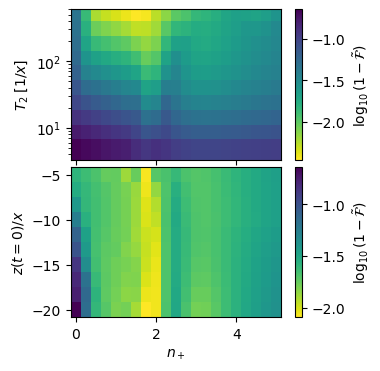

In [34]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3.4, 4))

fidelities = np.array([gamma_max_fidelity, z0_max_fidelity])

T2 = 1 / (2 * gamma_list)
im0 = axs[0].pcolormesh(n_plus, T2, np.log10(1 - gamma_max_fidelity.T), cmap='viridis_r')

axs[0].set_ylabel(r'$T_2 \;[1/ x]$')
axs[0].set_yscale('log')

im1 = axs[1].pcolormesh(n_plus, z0_list, np.log10(1 - z0_max_fidelity.T), cmap='viridis_r')

axs[1].set_xlabel(r'$n_+$')
axs[1].set_ylabel(r'$z(t=0) / x$')

cbar0 = plt.colorbar(im0, ax=axs[0], label=r'$\log_{10}(1 - \tilde{\mathcal{F}})$')
cbar1 = plt.colorbar(im1, ax=axs[1], label=r'$\log_{10}(1 - \tilde{\mathcal{F}})$')

fig.subplots_adjust(hspace=0.05)